## AttentiveFP: Pushing the Boundaries of Molecular Representation for Drug Discovery with the Graph Attention Mechanism

ABSTRACT: Hunting for chemicals with favorable pharmacological, toxicological, and pharmacokinetic properties
remains a formidable challenge for drug discovery. Deep
learning provides us with powerful tools to build predictive
models that are appropriate for the rising amounts of data, but
the gap between what these neural networks learn and what
human beings can comprehend is growing. Moreover, this gap
may induce distrust and restrict deep learning applications in
practice. Here, we introduce a new graph neural network
architecture called <code>AttentiveFP</code> for molecular representation that uses a graph attention mechanism to learn from relevant drug discovery datasets. We demonstrate that <code>AttentiveFP</code> achieves state-of-the-art predictive performances on a variety of datasets and that what it learns is interpretable. The feature visualization for <code>AttentiveFP</code> suggests that it automatically learns nonlocal intramolecular interactions from specified tasks, which can help us gain chemical insights directly from data beyond human perception.

Link to paper: https://pubs.acs.org/doi/pdf/10.1021/acs.jmedchem.9b00959

Credit: https://github.com/OpenDrugAI/AttentiveFP

Google Colab: https://colab.research.google.com/drive/1R-cFzUwz2N84e6vNB-1ZdTX3P1cof49Q?usp=sharing


In [1]:
# Clone the repository and cd into directory
!git clone https://github.com/saams4u/AttentiveFP.git
%cd AttentiveFP

Cloning into 'AttentiveFP'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 70 (delta 3), reused 7 (delta 2), pack-reused 61
Unpacking objects: 100% (70/70), done.
/content/AttentiveFP


### Example: Malaria Bioactivity

In [2]:
import os

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data

torch.manual_seed(8)

import time
import numpy as np
import gc
import sys

sys.setrecursionlimit(50000)

import pickle

torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')

# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True

import copy
import pandas as pd

In [3]:
# Install RDKit
!pip install rdkit-pypi==2021.3.1.5

     |████████████████████████████████| 18.0MB 295kB/s 


In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem, QED, rdMolDescriptors, MolSurf, rdDepictor
from rdkit.Chem.Draw import SimilarityMaps, rdMolDraw2D

%matplotlib inline
from numpy.polynomial.polynomial import polyfit

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

import seaborn as sns; sns.set()

from IPython.display import SVG, display

import sascorer

number of all smiles:  9999
number of successfully processed smiles:  9999
      Loge EC50                                             smiles
0      2.708050  COc1ccc(C)c2sc(nc12)N(Cc3cccnc3)C(=O)c4ccc(cc4...
1      2.708050               CC(Sc1ccc(Cl)cc1)C(=O)Nc2ccc(Br)cc2F
2      2.708050  Cc1ccc(cc1)S(=O)(=O)NCC(N2CCN(CC2)c3ccccc3F)c4...
3      2.708050       Cc1ccc2oc(nc2c1)c3cccc(NC(=O)C(Cl)(Cl)Cl)c3C
4      2.708050          FC(F)(F)c1cccc(NC(=O)C2=Cc3ccccc3OC2=O)c1
...         ...                                                ...
9994  -5.880997  CC[C@@]1(CCC(O1)[C@@]2(C)CC[C@@]3(C[C@@H](O)[C...
9995  -6.017809  CC1=CC(=O)OC[C@]23C[C@H](O)C(=C[C@H]2O[C@@H]4C...
9996  -6.019453      CCOC(=O)C(=O)N1c2ccc(OC)cc2C3=C(SSC3=S)C1(C)C
9997  -6.021511                  CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12
9998  -6.921854                   CC1(C)N=C(N)N=C(N)N1c2ccc(Cl)cc2

[9999 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


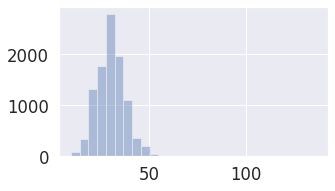

In [5]:
task_name = 'Malaria Bioactivity'
tasks = ['Loge EC50']

raw_filename = "data/malaria-processed.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')

smiles_tasks_df = pd.read_csv(raw_filename, names = ["Loge EC50", "smiles"])
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ", len(smilesList))

atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []

for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass

print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]

print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.distplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()

plt.savefig("atom_num_dist_"+prefix_filename+".png", dpi=200)
plt.show()
plt.close()

In [6]:
random_seed = 68
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 800

p_dropout= 0.03
fingerprint_dim = 200

weight_decay = 4.3 # also known as l2_regularization_lambda
learning_rate = 4
radius = 2
T = 1

per_task_output_units_num = 1 # for regression model
output_units_num = len(tasks) * per_task_output_units_num

In [7]:
import AttentiveLayers
import AttentiveLayers_viz

import Featurizer
import Featurizer_aromaticity_rm

import getFeatures
from getFeatures import save_smiles_dicts

import getFeatures_aromaticity_rm

if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)

# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
uncovered_df

feature dicts file saved as data/malaria-processed.pickle


,Loge EC50,smiles,cano_smiles


In [8]:
test_df = remained_df.sample(frac=0.2,random_state=random_seed)
train_df = remained_df.drop(test_df.index)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(len(test_df), sorted(test_df.cano_smiles.values))

2000 ['Brc1ccc2ncnc(NCC3CCCO3)c2c1', 'C#CCN(CC=C)Cc1nc(-c2cc(OC)ccc2OC)oc1C', 'C#CCN(Cc1cc2c(O)nc(N)nc2cc1C)c1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1', 'C#CCN(Cc1ccc2nc(N)nc(O)c2c1)c1ccc(C(=O)N[C@@H](CCC(=O)O)C(=O)O)cc1', 'C#CCSc1c(CCCC)cnc2c1c(=O)n(C)c(=O)n2C', 'C#CC[n+]1ccn2c(C)ccc2c1CC', 'C#Cc1cccc(NC(=O)[C@H](CC2CCCCC2)Nc2ccc(C#N)c3ccccc23)c1', 'C(#Cc1ccccc1)CN(Cc1ccccn1)Cc1ccccn1', 'C(=Cc1ccccc1)C=NNc1ccnc2ccccc12', 'C(=NNc1nc2ccccc2[nH]1)c1cccc(Oc2ccccc2)c1', 'C/C(=C\\c1csc(C)n1)[C@@H]1C[C@@H]2O[C@@H]2CCC[C@H](C)C(O)[C@@H](C)C(=O)C(C)(C)[C@@H](O)CC(=O)O1', 'C/C(C=C1Sc2ccc3ccoc3c2N1CCO)=C\\c1sc2ccc3occc3c2[n+]1CCO', 'C/C=C/C(C(=O)NCCCC)N1C(=O)c2cc(NC(C)=O)ccc2NC(=O)[C@@H]1C', 'C/C=C/[C@H]1O[C@@](O)([C@@H](C)C(O)C(C)[C@H]2OC(=O)C(OC)=CC(C)=C[C@@H](C)[C@H](O)C(CC)[C@@H](O)[C@H](C)CC(C)=CC=C[C@@H]2OC)C[C@@H](O[C@H]2C[C@@H](O)[C@H](OC(N)=O)[C@@H](C)O2)[C@@H]1C', 'C/C=C1/C[C@H]2[C@@H](OC)Nc3cc(O)c(OC)cc3C(=O)N2C1', 'C1=C(c2ccc(CN3CCCCC3)cc2)N2CCN=C2c2ccccc21', 'C1=CN(Cc2ccccc2)C=CC1=C1C=N

In [9]:
from AttentiveLayers import Fingerprint
from getFeatures import get_smiles_array

x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)

num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]

loss_function = nn.MSELoss()

model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])

print(params)

for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [10]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])

    #shuffle them
    np.random.shuffle(valList)
    batch_list = []

    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
        
    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)

        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        optimizer.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()

def eval(model, dataset):
    model.eval()
    test_MAE_list = []
    test_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []

    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 

    for counter, batch in enumerate(batch_list):
        batch_df = dataset.loc[batch,:]
        smiles_list = batch_df.cano_smiles.values
        print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
        print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        test_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        test_MSE_list.extend(MSE.data.squeeze().cpu().numpy())

    return np.array(test_MAE_list).mean(), np.array(test_MSE_list).mean()

In [11]:
best_param ={}

best_param["train_epoch"] = 0
best_param["test_epoch"] = 0

best_param["train_MSE"] = 9e8
best_param["test_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    test_MAE, test_MSE = eval(model, test_df)

    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE

    if test_MSE < best_param["test_MSE"]:
        best_param["test_epoch"] = epoch
        best_param["test_MSE"] = test_MSE

        if test_MSE < 1.1:
             torch.save(model, 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >2) and (epoch - best_param["test_epoch"] >18):        
        break
        
    print(epoch, train_MSE, test_MSE)
    
    train(model, train_df, optimizer, loss_function)

Streaming output truncated to the last 5000 lines.
        [-0.2405],
        [-0.5702],
        [-0.4328],
        [-0.3424],
        [-0.6913],
        [-1.1007],
        [-1.7524],
        [ 0.3732],
        [-0.8988],
        [-0.2757],
        [-2.5649],
        [-0.8163],
        [-1.3173],
        [-0.2572],
        [-1.1371],
        [-1.1295],
        [ 0.0405],
        [-1.0224],
        [-1.3242],
        [-0.7857],
        [-0.7580],
        [-1.0891],
        [-1.9349],
        [-2.6613],
        [ 0.0923],
        [-2.0675],
        [-1.1656],
        [-1.7320],
        [-0.0798],
        [-0.2989],
        [-1.5479],
        [-1.6282],
        [-1.2799],
        [-1.3100],
        [-0.9730],
        [ 0.0658],
        [-1.5036],
        [-0.2392],
        [-1.3781],
        [-2.9009],
        [-2.3212],
        [-0.7003],
        [-0.5294],
        [-0.6178],
        [-1.9307],
        [-1.4975],
        [-2.4591],
        [-2.3054],
        [-1.4007],
        [-2.4074],

In [12]:
# evaluate model
best_model = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["test_epoch"])+'.pt')     

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()

test_MAE, test_MSE = eval(model, test_df)
print("best epoch:", best_param["test_epoch"], "\n", "test MSE:", test_MSE)

     Loge EC50  ...                                        cano_smiles
0     0.184240  ...  COc1ccccc1C1CCN(C2CCC(NC(=O)/C=C/c3cc(C(F)(F)F...
1    -1.077439  ...  CCCN(CCC)CCCOc1ccc(C(=O)c2c(-c3ccc(OCCCN(CCC)C...
2    -0.075931  ...  CCCCCN1CCCN(Cc2cccc(NC(=O)c3ccc(Cl)c(Cl)c3)c2)CC1
3     2.708050  ...         CCc1c(C)nc(-n2nc(C)cc2NC(=O)c2ccccc2I)nc1O
4     0.341593  ...  COc1ccc(CNCCc2cccs2)cc1-c1ccc(OC)c(S(=O)(=O)NC...
..         ...  ...                                                ...
195  -2.477276  ...  O=C(NC1CCN(CC2(c3ccc(Cl)cc3)CCCCC2)CC1)c1cc[nH]n1
196   0.004068  ...  CC(Cc1ccc(NC(=O)c2ccc(CC(C)NCc3ccc(Cl)c(Cl)c3)...
197   2.708050  ...  CCOC(=O)C1C(CN(C)c2ccc(F)cc2)=NC(=O)NC1c1ccc(C...
198  -1.934005  ...  N#Cc1cccc(NC(=O)Nc2ccc(-c3ccc(-c4nc5cc(C(F)(F)...
199  -0.916291  ...           COc1cc2ncnc(NC3CCN(Cc4ccccc4)CC3)c2cc1OC

[200 rows x 3 columns]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 